# US Economy 2025 Outlook

In [226]:
from dotenv import load_dotenv
import os
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime

load_dotenv()

True

In [227]:
# Retrieve the API from .env folder
FRED_API = os.getenv("FRED_API")

### FED Federal Funds Rate - Target Range Chart

In [180]:
upper_limit_url = f'https://api.stlouisfed.org/fred/series/observations?series_id=DFEDTARU&api_key={FRED_API}&file_type=json'
lower_limit_url = f'https://api.stlouisfed.org/fred/series/observations?series_id=DFEDTARL&api_key={FRED_API}&file_type=json'

In [181]:
upper_response = requests.get(upper_limit_url)
lower_response = requests.get(lower_limit_url)

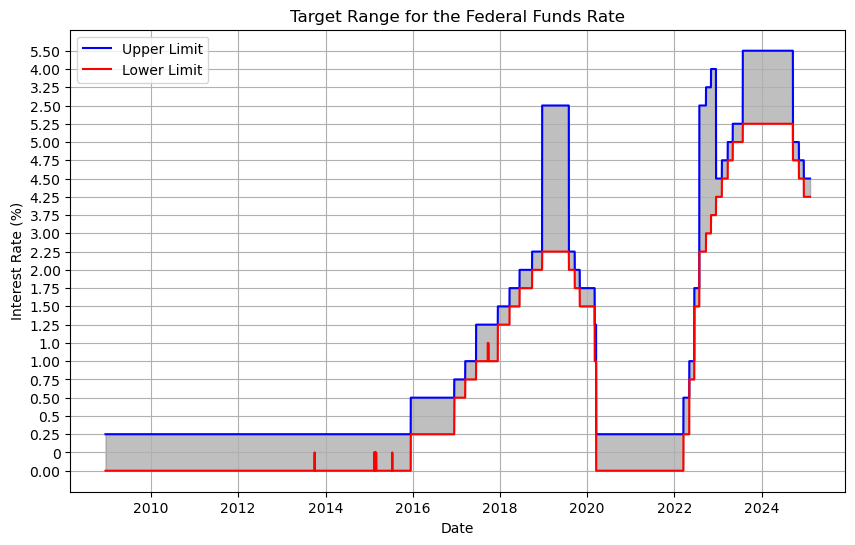

In [228]:
# check the responses
if upper_response.status_code == 200 and lower_response.status_code == 200:
    upper_data = upper_response.json()["observations"]
    lower_data = lower_response.json()["observations"]

    # Convert data to df
    upper_df = pd.DataFrame(upper_data)
    lower_df = pd.DataFrame(lower_data)

    # Convert date to datetime
    upper_df['date'] = pd.to_datetime(upper_df['date'])
    lower_df['date'] = pd.to_datetime(lower_df['date'])

    # Merge dataframes into a single/unified one
    df = pd.merge(upper_df[['date', 'value']], lower_df[['date', 'value']], on='date', suffixes=('_upper', '_lower'))

    # Plot the unified dataframe
    plt.figure(figsize=(10, 6))
    plt.fill_between(df['date'], df['value_lower'], df['value_upper'], color='gray', alpha=0.5)
    plt.plot(df['date'], df['value_upper'], label='Upper Limit', color='blue')
    plt.plot(df['date'], df['value_lower'], label='Lower Limit', color='red')
    plt.title('Target Range for the Federal Funds Rate')
    plt.xlabel('Date')
    plt.ylabel('Interest Rate (%)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Error when fetching data from FRED")

### Personal Consumption Expenditures Price Index

In [229]:
import beaapi
load_dotenv()
beakey = os.getenv("BEA_API")

In [232]:
# bea_tbl = beaapi.get_data(beakey, datasetname='NIPA', TableName='T20305', Frequency='Q', Year='2015')
# display(bea_tbl.head(2))

In [233]:
# API Request URL for Table 2.3.1 (with TableName parameter)
url = f"https://apps.bea.gov/api/data/?UserID={beakey}&method=GetData&datasetname=NIPA&TableID=T20301&TableName=Table%202.3.1&Frequency=Q&Year=ALL&ResultFormat=JSON"

# Fetch the data
response = requests.get(url)
data = response.json()

# Check if the data contains any errors
if "Error" in data:
    print("Error:", data["Error"]["APIErrorDescription"])
else:
    print("Data retrieved successfully.")

Data retrieved successfully.


### CPI

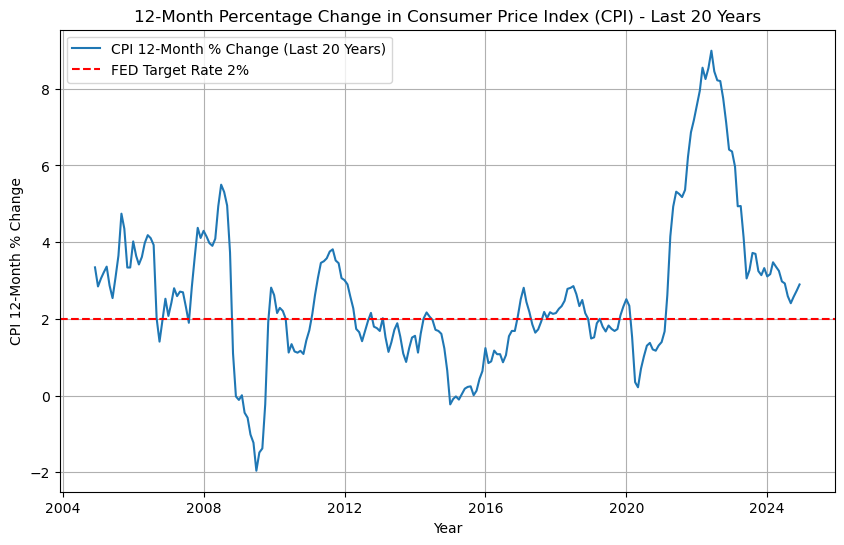

In [237]:
series_id = 'CPIAUCSL'  # Consumer Price Index for All Urban Consumers
url = f'https://api.stlouisfed.org/fred/series/observations'

# Set up parameters for the API request
params = {
    'series_id': series_id,
    'api_key': FRED_API,
    'file_type': 'json',
    'frequency': 'm',  # Monthly data
    'limit': 1000,  # Number of data points to retrieve
}

# Make the GET request to FRED API
response = requests.get(url, params=params)
data = response.json()

# Process the data into a pandas DataFrame
observations = data['observations']
dates = [obs['date'] for obs in observations]
values = [float(obs['value']) if obs['value'] != '.' else None for obs in observations]

# Create a pandas DataFrame
cpi_df = pd.DataFrame({
    'Date': pd.to_datetime(dates),
    'CPI': values
})

# Calculate the 12-month percentage change in CPI
cpi_df['CPI_12mo_pct_change'] = cpi_df['CPI'].pct_change(periods=12) * 100

# Drop rows with missing values (first 12 months will have NaN)
cpi_df.dropna(subset=['CPI_12mo_pct_change'], inplace=True)

# Filter data for the last 20 years
end_date = cpi_df['Date'].max()
start_date = end_date - pd.DateOffset(years=20)
cpi_df_last_20_years = cpi_df[cpi_df['Date'] >= start_date]

# Plot the 12-month percentage change for the last 20 years
plt.figure(figsize=(10, 6))
plt.plot(cpi_df_last_20_years['Date'], cpi_df_last_20_years['CPI_12mo_pct_change'], label='CPI 12-Month % Change (Last 20 Years)')

# Add a horizontal dashed line at y = 2
plt.axhline(y=2, color='red', linestyle='--', label='FED Target Rate 2%')

# Customize the plot
plt.title('12-Month Percentage Change in Consumer Price Index (CPI) - Last 20 Years')
plt.xlabel('Year')
plt.ylabel('CPI 12-Month % Change')
plt.grid(True)
plt.legend()  # Displays the legend for both lines

# Show the plot
plt.show()

In [236]:
# cpi_df_last_20_years.tail()

### Immigration Policies and Unemployment - Chart

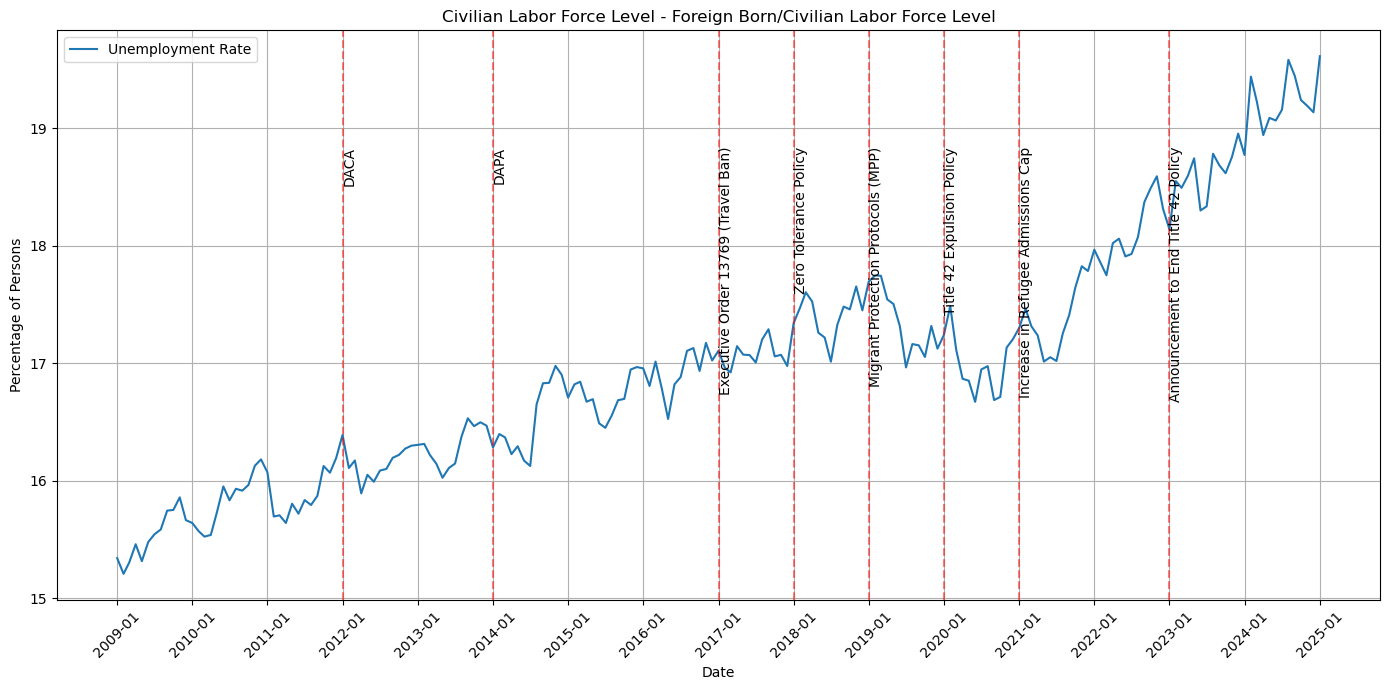

In [238]:
immigration_events = [
    {"event": "DACA", "date": "2012"},
    {"event": "DAPA", "date": "2014"},
    {"event": "Executive Order 13769 (Travel Ban)", "date": "2017"},
    {"event": "Zero Tolerance Policy", "date": "2018"},
    {"event": "Migrant Protection Protocols (MPP)", "date": "2019"},
    {"event": "Title 42 Expulsion Policy", "date": "2020"},
    {"event": "Increase in Refugee Admissions Cap", "date": "2021"},
    {"event": "Announcement to End Title 42 Policy", "date": "2023"}
]

# Read the CSV file
df = pd.read_csv("data/LNU01073395_LNU01000000.csv")
df['observation_date'] = pd.to_datetime(df['observation_date'])

# Convert event dates to datetime
for event in immigration_events:
    event['date'] = datetime.strptime(event['date'], "%Y")

# Plot the data
plt.figure(figsize=(14, 7))
plt.plot(df['observation_date'], df['LNU01073395_LNU01000000']*100, label='Unemployment Rate')

# Add event markers
for event in immigration_events:
    plt.axvline(x=event['date'], color='r', linestyle='--', alpha=0.5)
    plt.text(event['date'], plt.ylim()[1]*0.95, event['event'], rotation=90, verticalalignment='top')

# Formatting
plt.title('Civilian Labor Force Level - Foreign Born/Civilian Labor Force Level')
plt.xlabel('Date')
plt.ylabel('Percentage of Persons')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()

### Unemployment Rate Chart

In [239]:
df = pd.read_csv("data/UnemploymentData.csv")
# df = df.rename(columns={'LNU01073395_LNU01000000': 'UnemploymentRate'})
df.head()

,Series ID,Year,Period,Value
0,LNS14000000,2015,M01,5.7
1,LNS14000000,2015,M02,5.5
2,LNS14000000,2015,M03,5.4
3,LNS14000000,2015,M04,5.4
4,LNS14000000,2015,M05,5.6


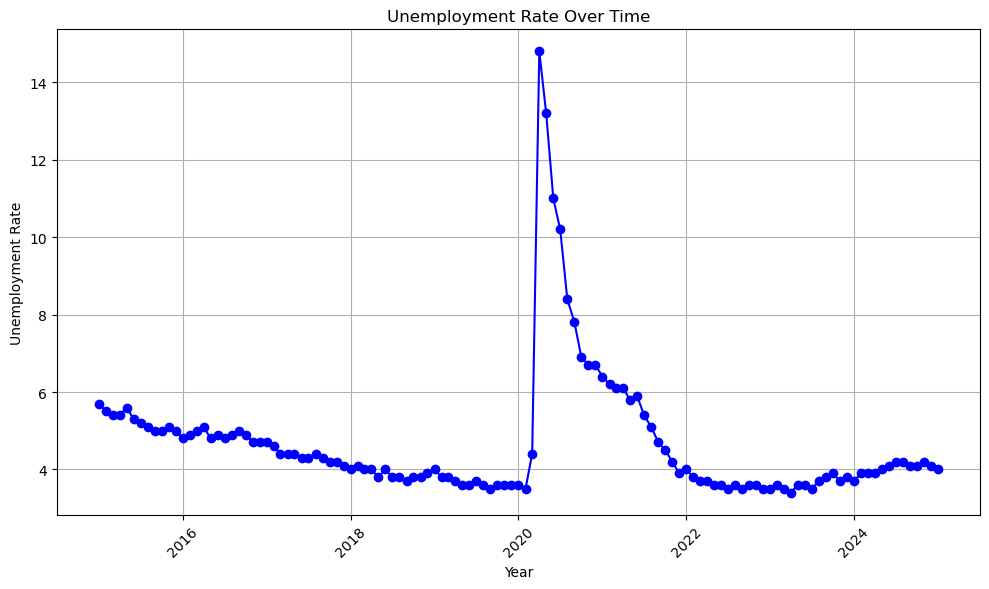

In [240]:
# Combine Year and Period into a single Date column
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Period'].str[1:], format='%Y-%m')

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Value'], marker='o', linestyle='-', color='b')

# Label the chart
plt.title('Unemployment Rate Over Time')
plt.xlabel('Year')
plt.ylabel('Unemployment Rate')
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

### Productivity Chart

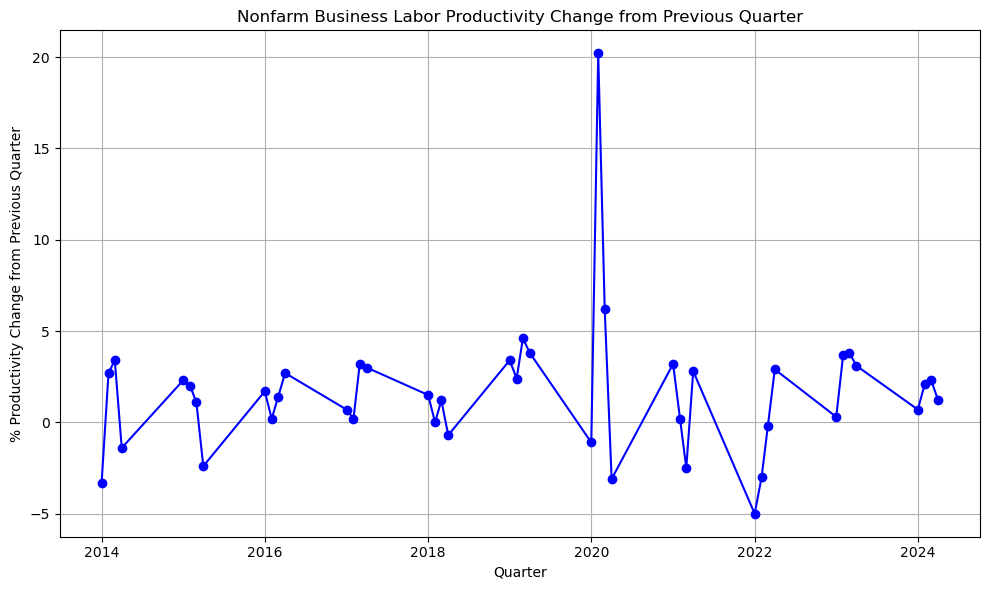

In [177]:
df = pd.read_csv("data/ProductivityData.csv")

df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Period'].str[1:], format='%Y-%m')

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Value'], marker='o', linestyle='-', color='b')

# Label the chart
plt.title('Nonfarm Business Labor Productivity Change from Previous Quarter')
plt.xlabel('Quarter')
plt.ylabel('% Productivity Change from Previous Quarter')
plt.xticks(rotation=0)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

### US Products Imports by Country

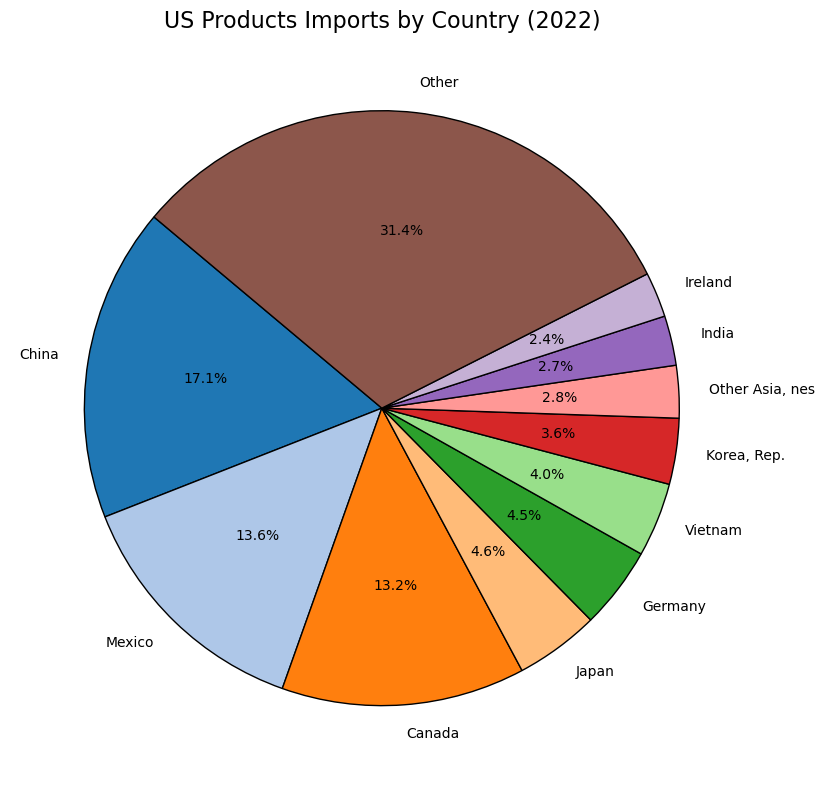

In [210]:
df = pd.read_excel("data/WITS-Partner.xlsx", sheet_name='Partner')
df.head()

# Filter for imports (Trade Flow = "Import")
imports_df = df[df['Trade Flow'] == 'Import']

# Sort by import value in descending order
imports_df = imports_df.sort_values(by='Import (US$ Thousand)', ascending=False)

# Select the top N countries (e.g., top 10)
top_n = 10
top_imports_df = imports_df.head(top_n)

# Sum the import values of all other countries
other_imports = imports_df['Import (US$ Thousand)'][top_n:].sum()

# Add the "Other" category to the top countries DataFrame
other_row = pd.DataFrame({
    'Partner Name': ['Other'],
    'Import (US$ Thousand)': [other_imports]
})

top_imports_df = pd.concat([top_imports_df, other_row], ignore_index=True)

# Create a pie chart
plt.figure(figsize=(10, 8))
plt.pie(
    top_imports_df['Import (US$ Thousand)'],  # Values for the pie chart
    labels=top_imports_df['Partner Name'],    # Labels for each slice
    autopct='%1.1f%%',                        # Display percentages
    startangle=140,                           # Rotate the chart for better readability
    colors=plt.cm.tab20.colors,               # Use a color map for distinct colors
    wedgeprops={'edgecolor': 'black'}         # Add black edges to slices
)

# Add a title
plt.title('US Products Imports by Country (2022)', fontsize=16)

# Display the chart
plt.tight_layout()
plt.show()

### Scenarios for the U.S. economy in 2025 - Chart

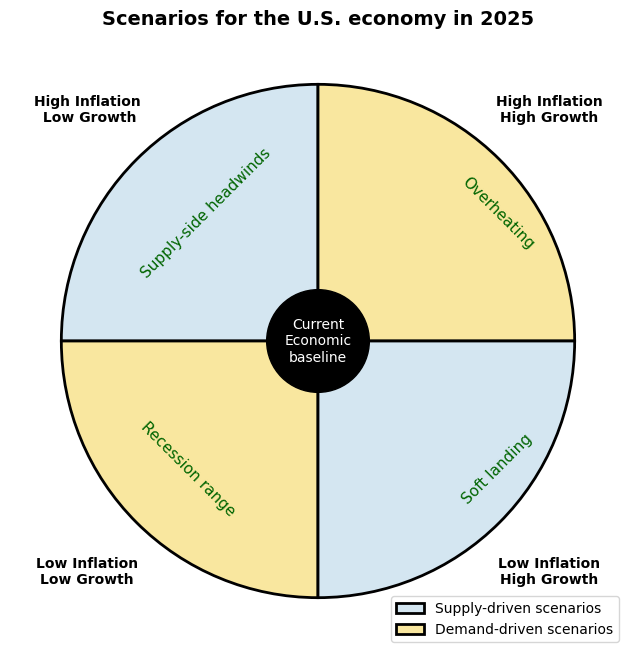

In [242]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge, Circle

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)
ax.set_aspect('equal')

# Define colors for quadrants
color1 = "#d4e6f1"  # Quadrants 0-90 and 180-270 degrees
color2 = "#f9e79f"  # Quadrants 90-180 and 270-360 degrees

# Add quadrants
quadrants = [
    (Wedge((0, 0), 1, 90, 180, facecolor=color1, edgecolor='black', linewidth=2), "Supply-side headwinds"),
    (Wedge((0, 0), 1, 0, 90, facecolor=color2, edgecolor='black', linewidth=2), "Overheating"),
    (Wedge((0, 0), 1, 180, 270, facecolor=color2, edgecolor='black', linewidth=2), "Recession range"),
    (Wedge((0, 0), 1, 270, 360, facecolor=color1, edgecolor='black', linewidth=2), "Soft landing"),
]

for wedge, label in quadrants:
    ax.add_patch(wedge)

# Add inner circle for economic baseline
ax.add_patch(Circle((0, 0), 0.2, color="black"))
ax.text(0, 0, "Current\nEconomic\nbaseline", ha='center', va='center', fontsize=10, color='white')

# Labels for each quadrant
ax.text(-0.9, 0.9, "High Inflation\n Low Growth", ha='center', va='center', fontsize=10, fontweight='bold')
ax.text(0.9, 0.9, "High Inflation\nHigh Growth", ha='center', va='center', fontsize=10, fontweight='bold')
ax.text(-0.9, -0.9, "Low Inflation\nLow Growth", ha='center', va='center', fontsize=10, fontweight='bold')
ax.text(0.9, -0.9, "Low Inflation\nHigh Growth", ha='center', va='center', fontsize=10, fontweight='bold')

# Titles for scenario areas
ax.text(-0.7, 0.5, "Supply-side headwinds", fontsize=11, color='darkgreen', va='center', rotation=45)
ax.text(0.7, 0.5, "Overheating", fontsize=11, color='darkgreen', ha='center', va='center', rotation=-45)
ax.text(-0.7, -0.5, "Recession range", fontsize=11, color='darkgreen', va='center', rotation=-45)
ax.text(0.7, -0.5, "Soft landing", fontsize=11, color='darkgreen', ha='center',va='center', rotation=45)

# Legend
legend_patches = [
    Wedge((0, 0), 0.1, 0, 90, facecolor=color1, edgecolor='black', linewidth=2),
    Wedge((0, 0), 0.1, 0, 90, facecolor=color2, edgecolor='black', linewidth=2)
]
ax.legend(legend_patches, ["Supply-driven scenarios", "Demand-driven scenarios"], loc="lower right")

# Title
plt.title("Scenarios for the U.S. economy in 2025", fontsize=14, fontweight='bold')

# Show plot
plt.show()
